<font size="5"><b><center>SJG017 - DK118: Protein acceleration workflow</center></b></font>

<font size = 4><b><center>ADT clusters and TMM UMAP</center></b></font>

In [1]:
import anndata
import scvelo as scv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import protaccel.protaccel as pa
import velocyto as vcy

Import Seurat object integrated with spliced and unspliced counts.

In [2]:
vlm = vcy.VelocytoLoom("DK118.loom")

Import protein count data.

pa.import_prot_data: Imports and parses csv file with feature barcoding information, located at file_path
- Format: rows = ADT (antibody-derived tag) names, columns = cells.  
- Outputs numpy array of gene counts, cell indices, and observed ADT names.

In [3]:
[prot_count_array, prot_cells, adt_names] = pa.import_prot_data("/scratch/karjosukarso/DK-118/multimodal/DK118_CITEseq_TMM.csv")

Define relationship between proteins and source mRNA.

Problem: not all the genes in our manually curated list of protein:mRNA(s) relations are present in the loom file, thus, we have to filter them.

In [4]:
relations = pd.read_excel("protein_mRNA.xlsx", header = None, index_col = 0)
relations.index = adt_names
gene_dict = {ADT : list(relations.loc[ADT][~pd.isnull(relations.loc[ADT])]) for ADT in relations.index}
mrna_targets = list(gene_dict.values())
flatten = lambda t: [item for sublist in t for item in sublist]
mrna_targets = flatten(mrna_targets)
filtered_gene_dict = {}
for gene in set(mrna_targets).intersection(set(vlm.ra["Gene"])):
    for protein in [ADT for ADT, mRNAs in gene_dict.items() if gene in mRNAs]:
        if filtered_gene_dict.get(protein, 0) == 0:
            filtered_gene_dict[protein] = [gene]
        else:
            filtered_gene_dict[protein] += [gene]
            
gene_dict = filtered_gene_dict
InvertDict = lambda d: dict((v,k) for k in d for v in d[k])
prot_dict = InvertDict(gene_dict)
mrna_targets = list(prot_dict.keys())

Append genes that yield observed proteins even if variability is relatively low for RNA velocity phase plots.

pa.enforce_protein_filter: forces velocyto filters to retain genes that have protein information, even if they are substandard for RNA velocity. Stores ADT names and corresponding mRNA names in the velocyto loom structure vlm.

In [5]:
pa.enforce_protein_filter(vlm, mrna_targets, adt_names)

pa.shared_cells_filter: retains only cells with protein and RNA information. Reports the number of cells in each array. Requires the location of the first and last characters of the cell barcode in the vlm structure. The cell tages in csv are presumde to be pre-processed. Removes cells with zero cell size in each variable. Saves protein count array as vlm.P.

In [6]:
[prot_count_array, shared_cells, prot_cells] = pa.shared_cells_filter(vlm = vlm, prot_cells = prot_cells, prot_count_array = prot_count_array, first_char = 0, last_char = 0, filter_empty_cells = True, min_cell_size = 0)

ADT cell number: 2067
RNAseq cell number: 2064
Shared cells: 2064
Shared cells with more than 0 molecules: 2064


pa.impute: nearest-neighbor imputation function that smoothes using a kNN connection graph. The connection basis may be either protein space P or spliced molecule space S. If size-normalization is used, imputation is performed on log2-normalized counts rather than log counts. If imputation in PCA space is used, PCA-transformed space is used to construct kNN connection graph.

In [7]:
pa.impute(vlm, prot_count_array, k = 400, impute_in_prot_space = True, size_norm = False, impute_in_pca_space = False)

We do not need to identify the clusters because we can assign our previously computed ones.Here, we will use the ADT clusters.

In [8]:
vlm.cluster_ID = vlm.ca["adtClusterID"]
vlm.num_clusters = len(np.unique(vlm.ca["adtClusterID"]))

In [9]:
COLORS = np.asarray([[0, 0.4470, 0.7410],
        [0.8500, 0.3250, 0.0980],
        [0.9290, 0.6940, 0.1250],
        [0.4940, 0.1840, 0.5560],
        [0.4660, 0.6740, 0.1880],
        [0.6660, 0.4740, 0.1880]])

cluster_labels = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"]
vlm.COLORS = COLORS
vlm.labels = cluster_labels

pa.fit_pcs calculates PCA for top n_pcs components using used-selected space "space_name". Stores as "pc_name". Stores the linear transformation (pc_name_fit) used to generate the PCA space. Here, the space name is the protein space, and we will visualize clusters in PC1/2 and PC2/3.

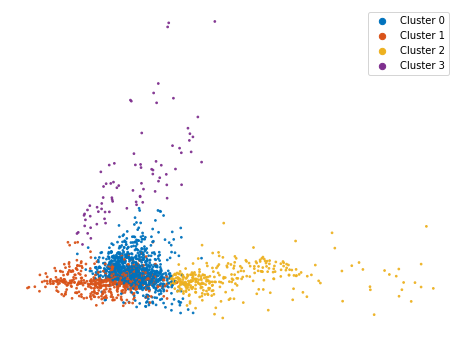

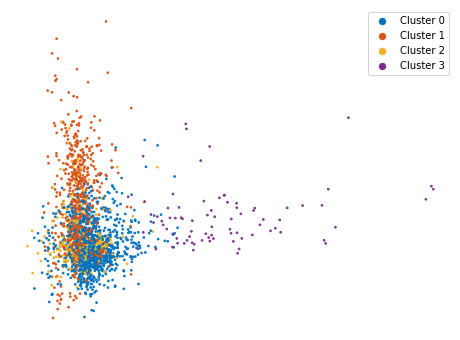

In [10]:
pa.fit_pcs(vlm, "P_norm", "prot_pcs", n_pcs = 4)
pa.visualize_pcs(vlm, [1,2])
pa.visualize_pcs(vlm, [2,3])

pa.visualize_protein_markers: Visualizes an array of protein markers in protein principal component space. The components to plot are given by the list pc_targets. If visualize_clusters is selected, an additional cluster-colored plot is generated. Useful for iterative manual procedure to identify clusters based on characteristic markers.

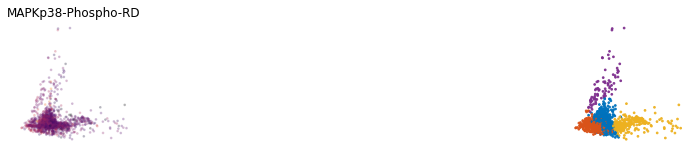

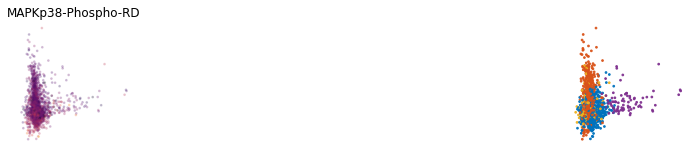

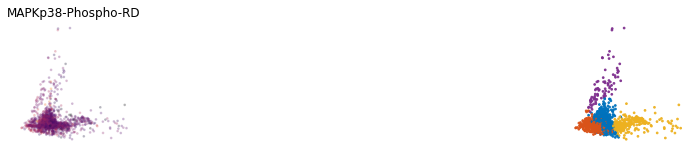

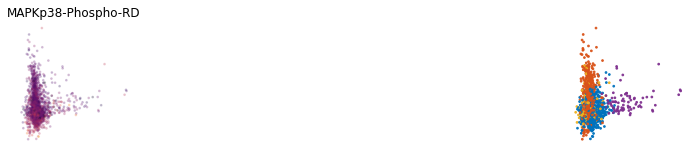

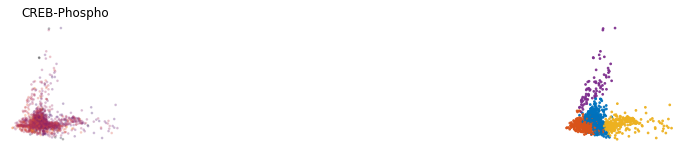

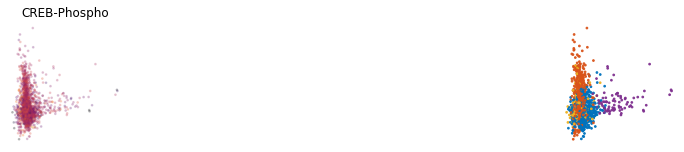

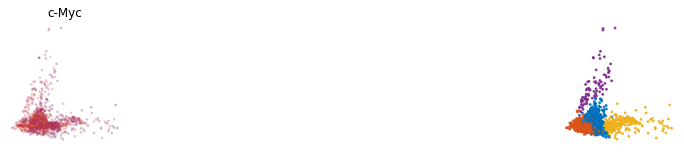

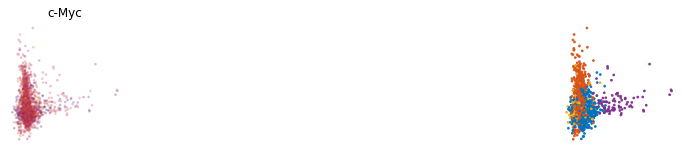

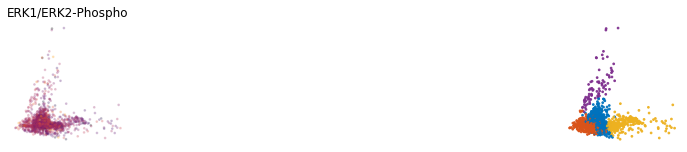

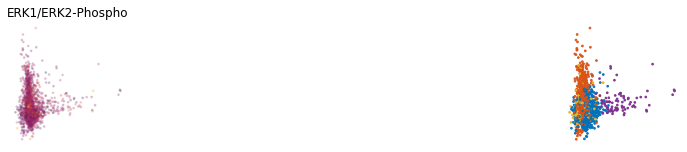

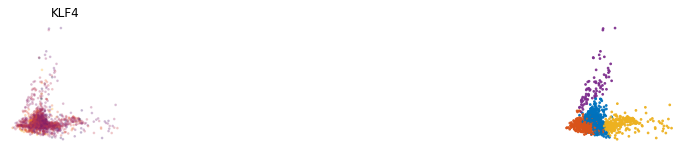

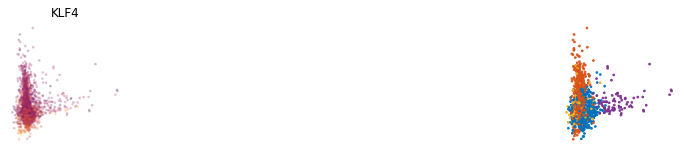

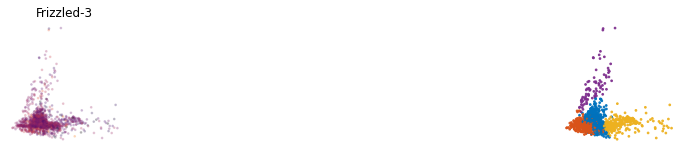

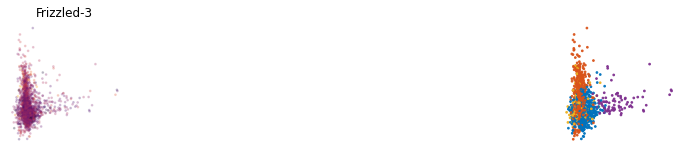

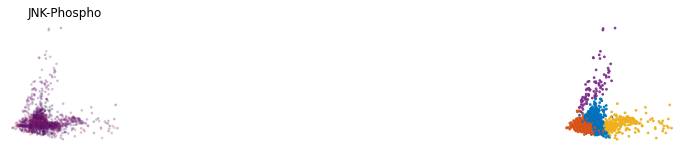

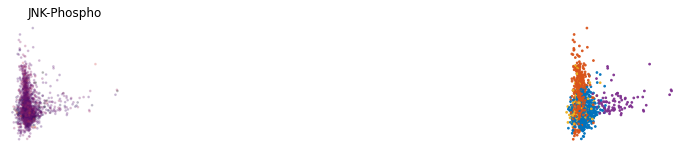

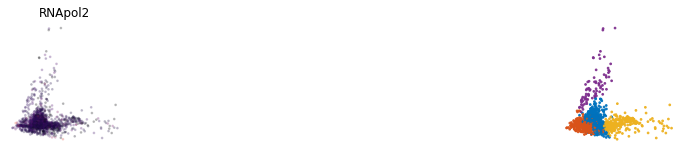

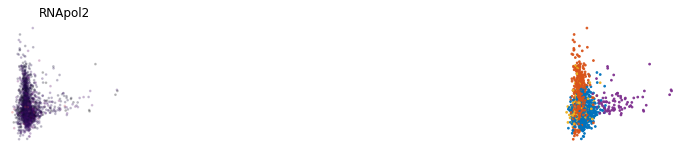

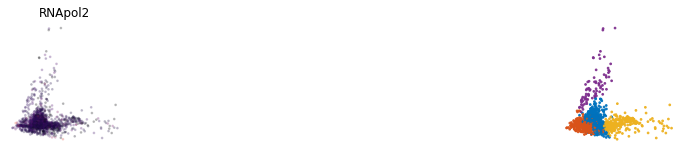

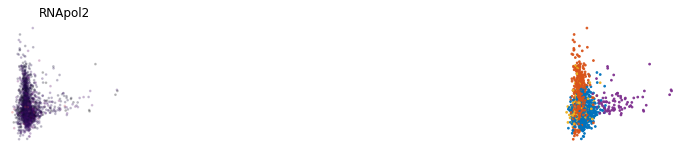

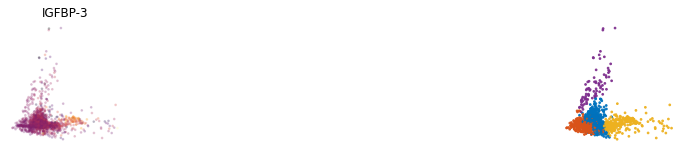

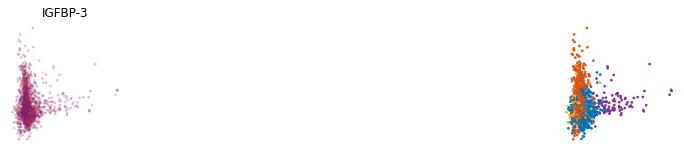

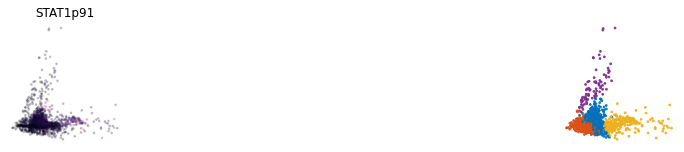

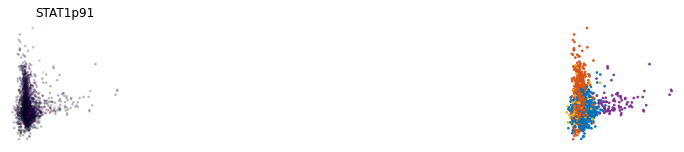

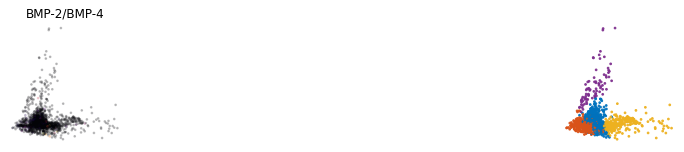

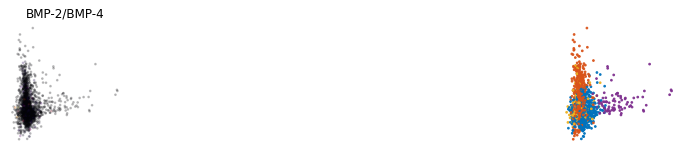

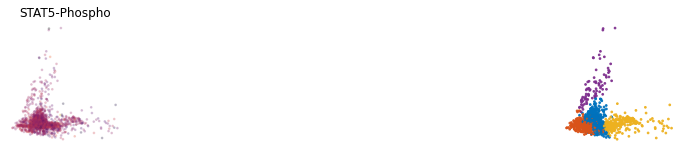

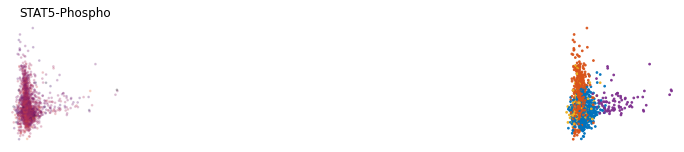

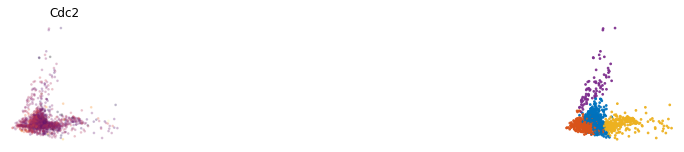

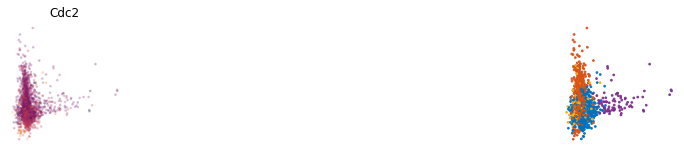

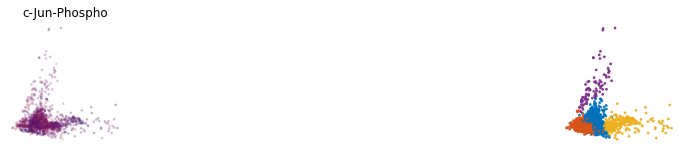

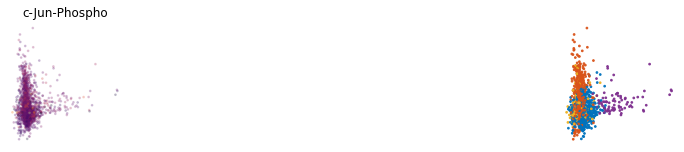

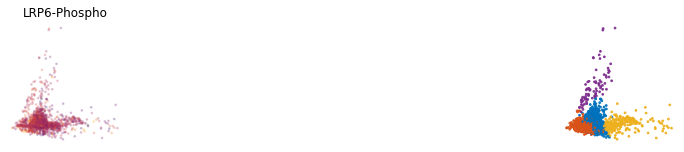

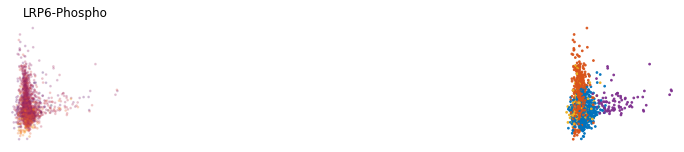

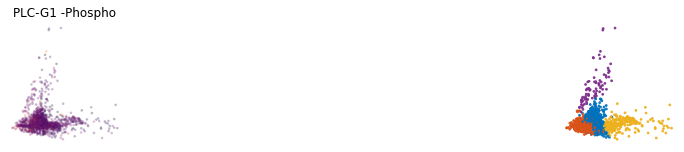

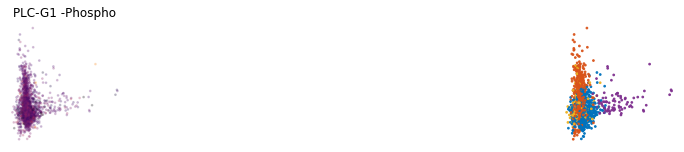

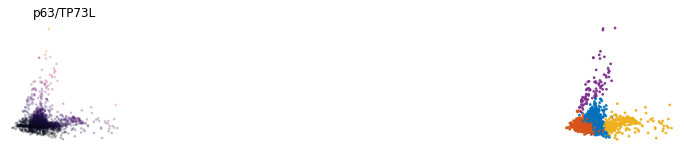

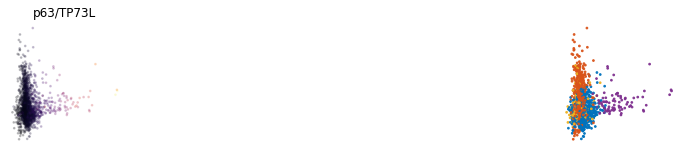

In [11]:
marker_list = list(prot_dict.values())
for marker in marker_list:
    pa.visualize_protein_markers(vlm, protein_markers = [marker], pc_targets = [1,2], visualize_clusters = True)
    plt.savefig("fig_RNAprotvel_ADTclusters_CustomUMAPtmm/protein_marker_"+str(marker.replace("/","-"))+"_PC_1-2.svg", dpi = 700)
    pa.visualize_protein_markers(vlm, protein_markers= [marker], pc_targets = [2,3], visualize_clusters = True)
    plt.savefig("fig_RNAprotvel_ADTclusters_CustomUMAPtmm/protein_marker_"+str(marker.replace("/","-"))+"_PC_2-3.svg", spi = 700)

Since we need a 1-to-1 correspondence between proteins and mRNAs, we arbitrarily retain POLR2B and remove POLR2D.

In [12]:
genes_used_for_prot_velocity = mrna_targets
adt_used_for_prot_velocity = list(prot_dict.values())

Import PCA from Seurat.

In [13]:
setattr(vlm, "pcs", vlm.ca["X_pca"])

Fit degradation parameters; extrapolate.

In [14]:
pa.gamma_fit(vlm, "Sx", "Ux", "rna")
pa.extrapolate(vlm, vel_type = "rna")
pa.gamma_fit(vlm, "Px", "Sx", "protein", genes_used_for_prot_velocity, adt_used_for_prot_velocity)
pa.extrapolate(vlm, vel_type = "protein")

Examine parameter fits.

In [15]:
n_rna_velo_fit_viz = 227
np.random.seed(1)

print(str(len(vlm.rna_velo_gene_ind))+" spliced/unspliced gene pairs have diagonal phase portraits by R2. Displaying "\
      +str(n_rna_velo_fit_viz)+" random phase portraits:")
genes_for_rna_velo_fit=np.random.choice(vlm.rna_velo_gene_ind,n_rna_velo_fit_viz, replace=True)

227 spliced/unspliced gene pairs have diagonal phase portraits by R2. Displaying 227 random phase portraits:


pa.visualize_phase_portraits: plots imputed or raw phase portraits for protein or RNA velocity using a panel of genes (markers). If protein velocity plots are desired, a dictionary (prot_dict) must be passed into the function to define the relationship between each gene and the protein markers. plot_fit plots the linear fit for RNA velocity.

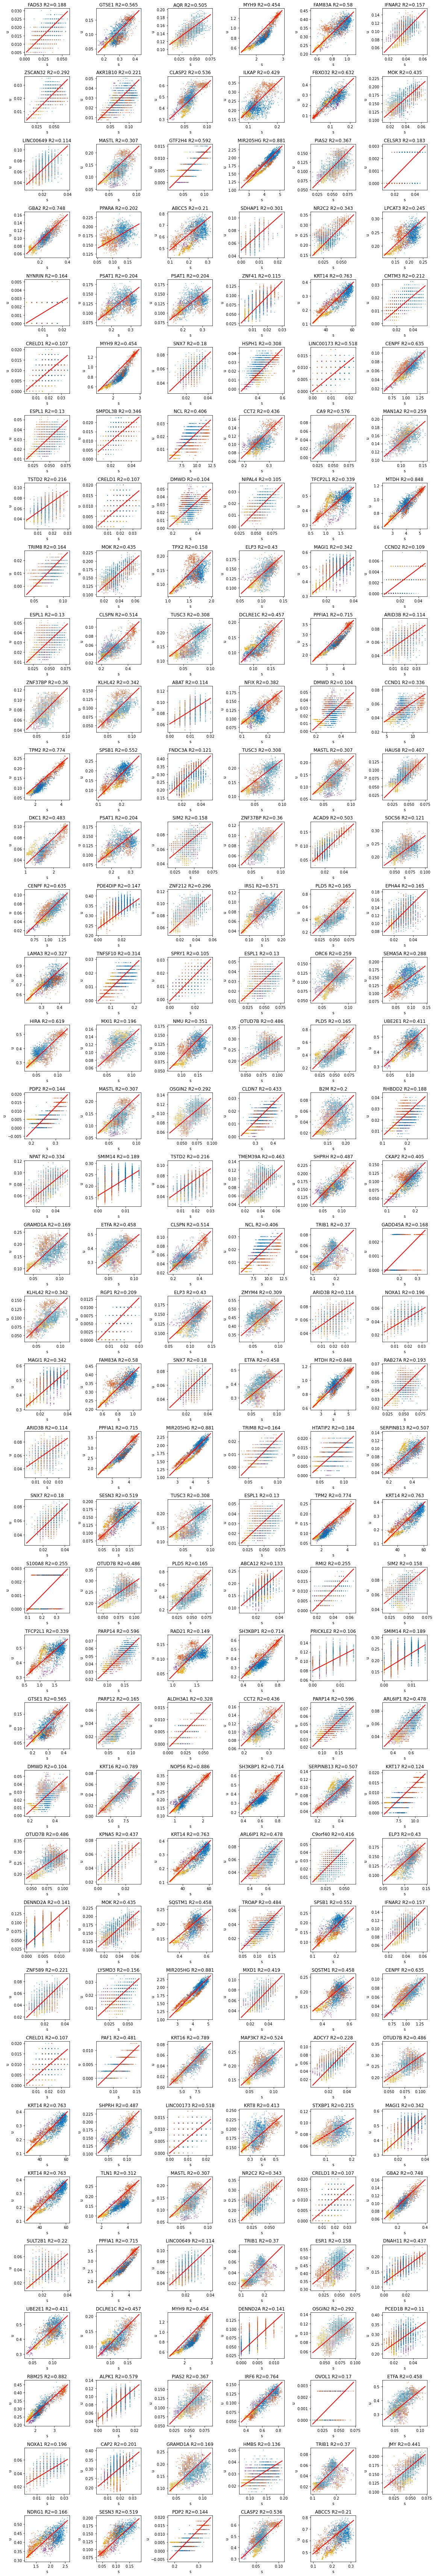

In [16]:
rna_vel_genes = vlm.ra["Gene"][genes_for_rna_velo_fit]
pa.visualize_phase_portraits(vlm, rna_vel_genes, target = "mrna", plot_fit = True)
plt.savefig("fig_RNAprotvel_ADTclusters_CustomUMAPtmm/RNAvelocity_phase_portraits.svg", dpi = 700)

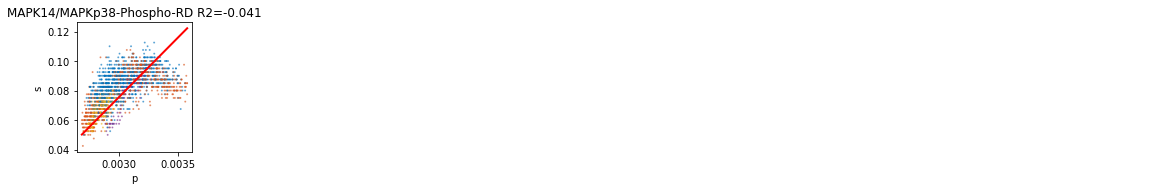

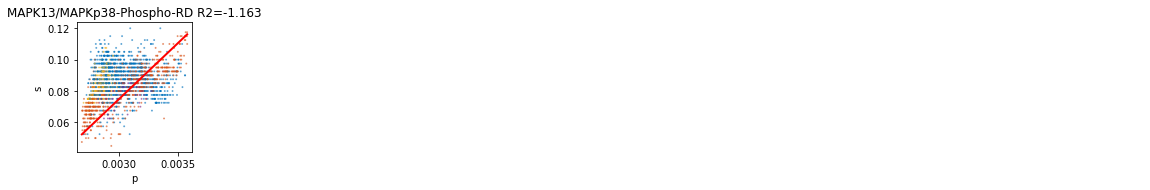

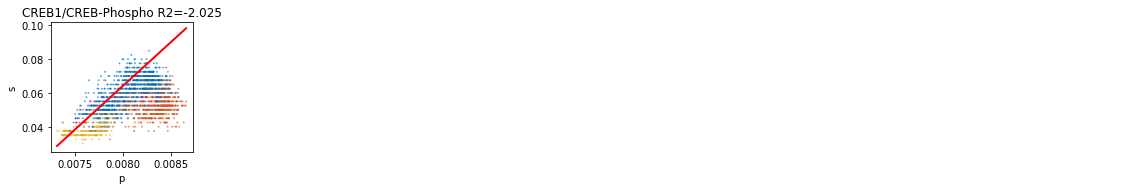

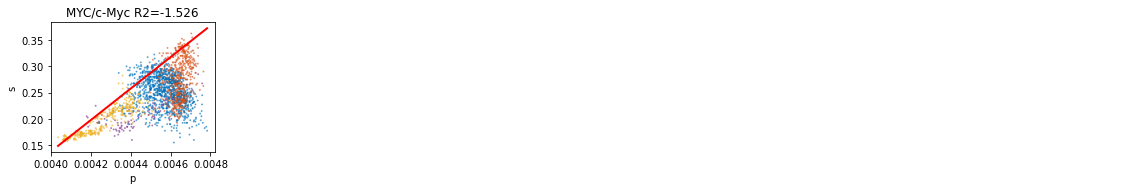

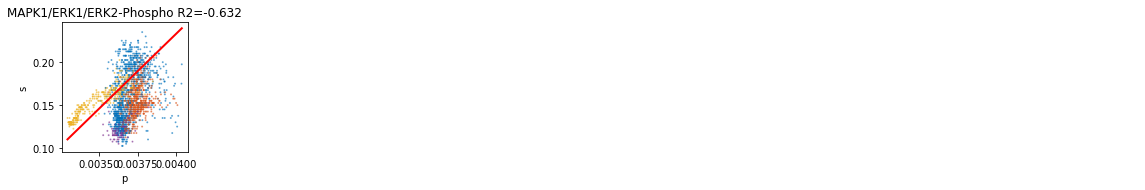

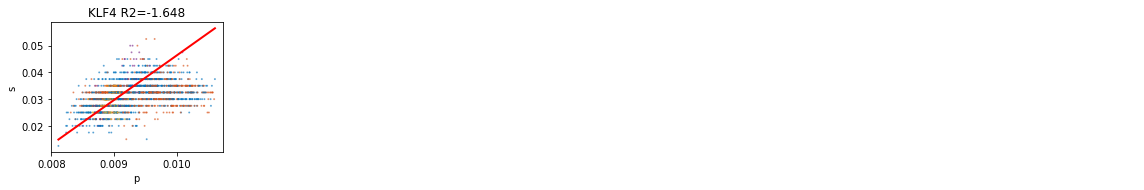

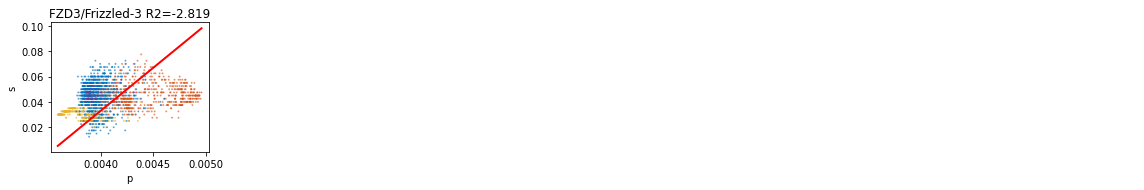

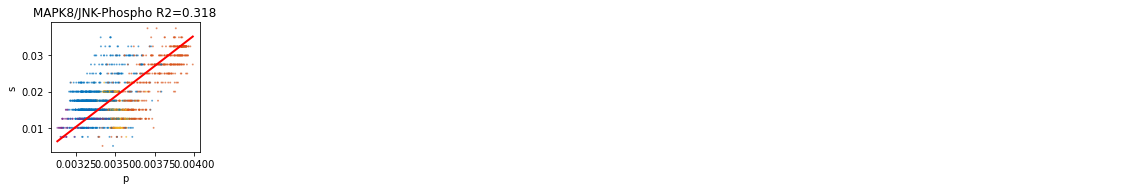

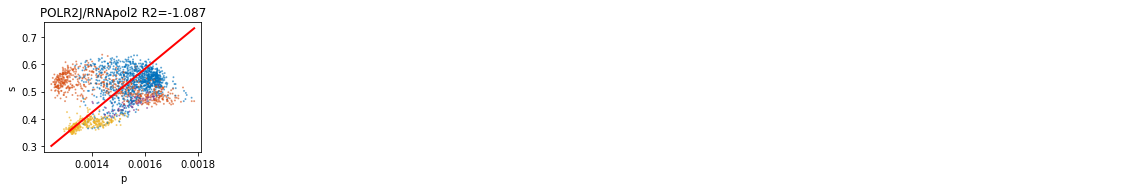

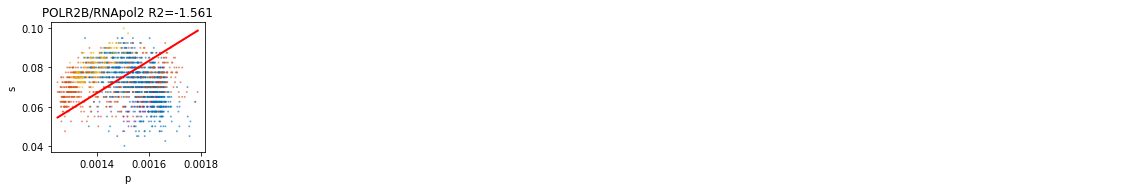

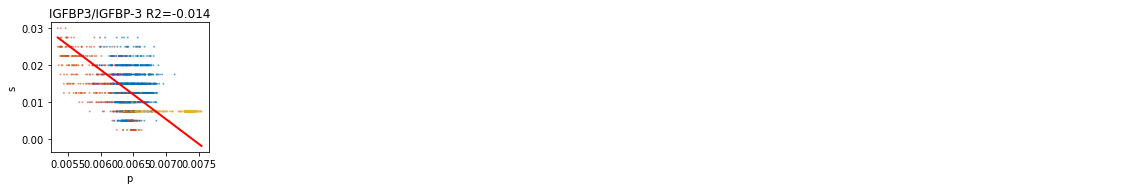

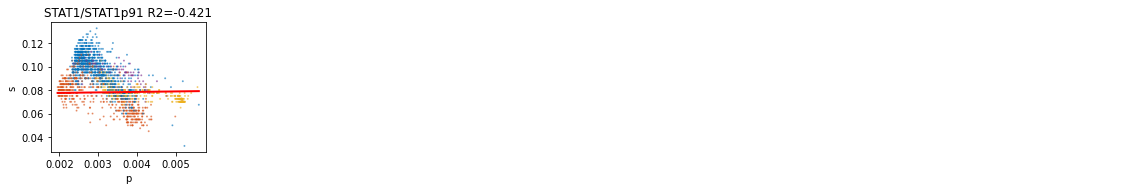

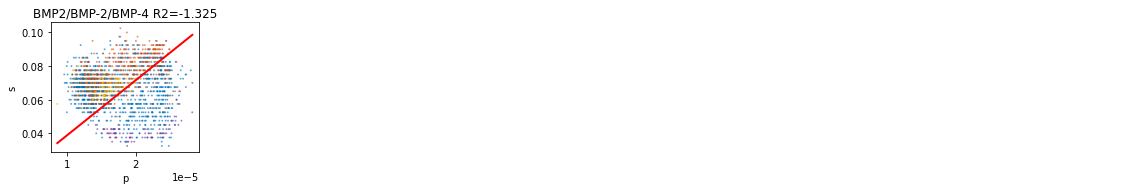

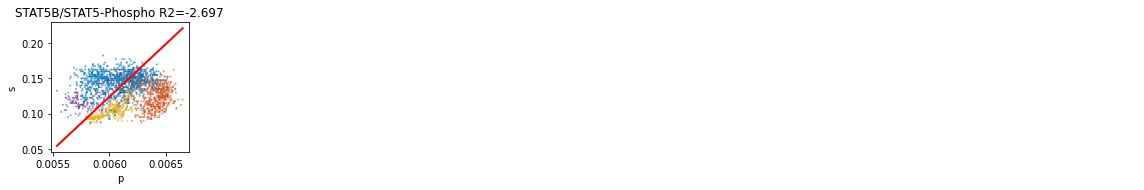

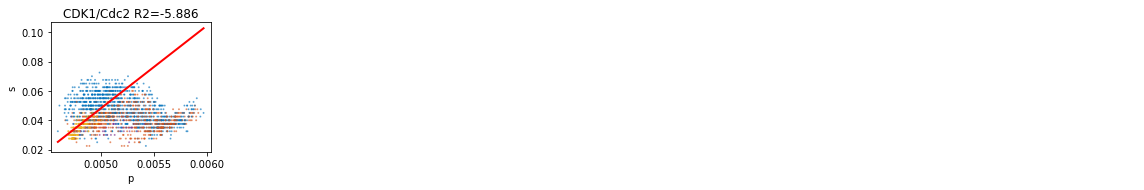

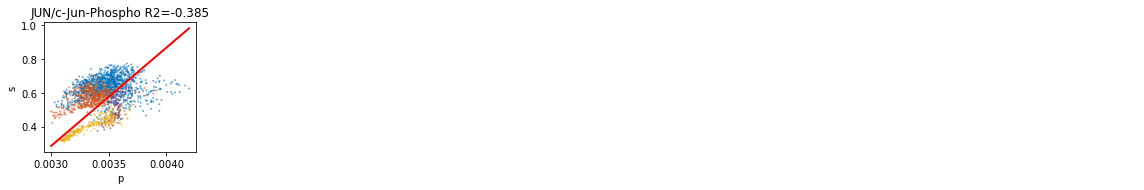

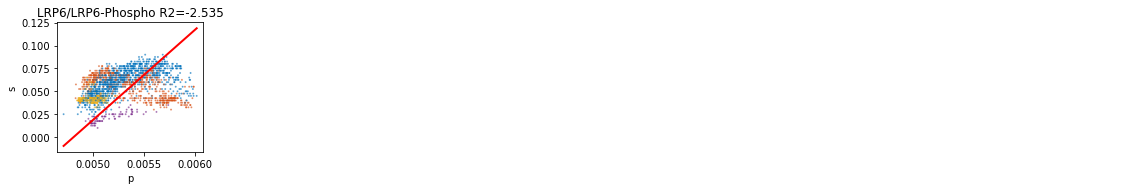

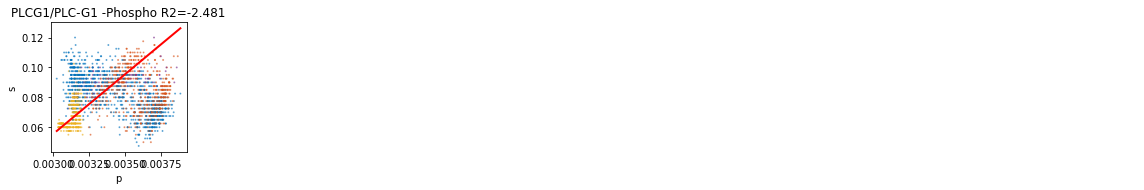

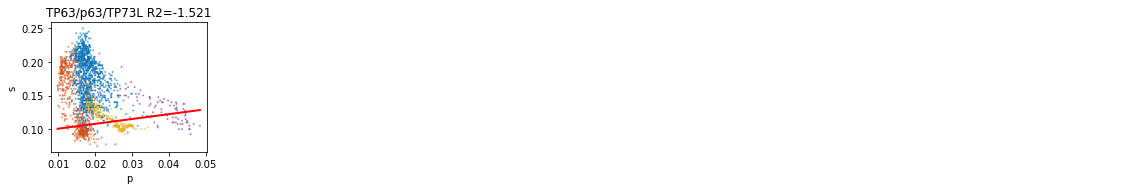

In [17]:
for marker in mrna_targets:
    pa.visualize_phase_portraits(vlm, [marker], target = "protein", imputed = True, prot_dict = prot_dict, plot_fit = True)
    plt.savefig("fig_RNAprotvel_ADTclusters_CustomUMAPtmm/phase_portrait_"+marker+".svg", dpi = 700)

Project velocity direction into the embedding using the transition matrix method.

RNA velocities:

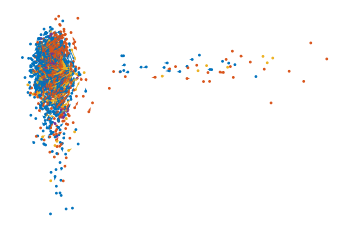

In [18]:
pa.identify_embedding_knn(vlm, "pcs", [1,2])
pa.calculate_embedding_delta(vlm, "Sx", "delta_S", "delta_S_in_S_pca", "rna_velo_gene_ind")
pa.visualize_velocity_projection(vlm, "delta_S_in_S_pca")

Protein velocities:

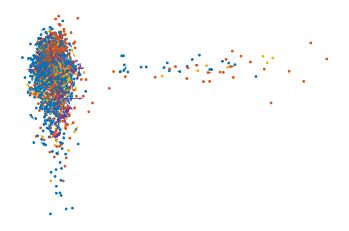

In [19]:
pa.calculate_embedding_delta(vlm, "Px", "delta_P", "delta_P_in_S_pca", "prot_velo_prot_ind")
pa.visualize_velocity_projection(vlm, "delta_P_in_S_pca")

Visualize cluster-specific velocities.

RNA velocities:

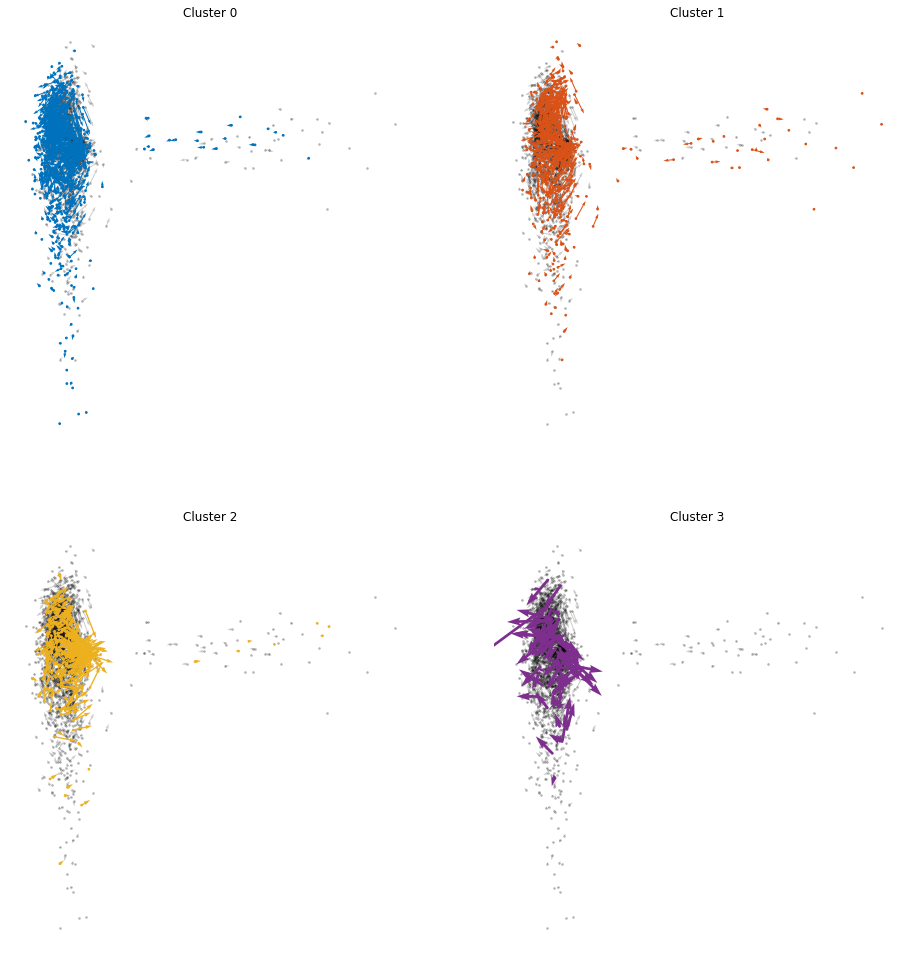

In [20]:
pa.cluster_specific_plot(vlm, "delta_S_in_S_pca", draw_cells = True)
plt.savefig("fig_RNAprotvel_ADTclusters_CustomUMAPtmm/cluster_specific_RNA_vel_PCA.svg", dpi = 700)

Protein velocities:

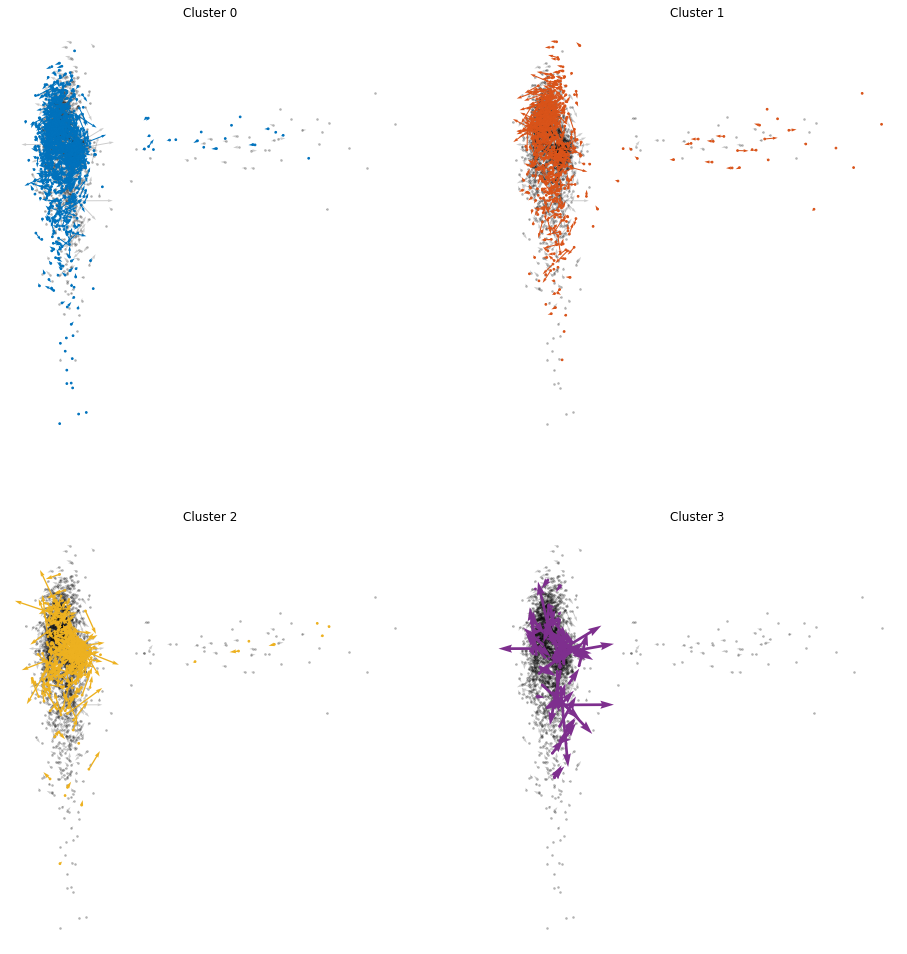

In [21]:
pa.cluster_specific_plot(vlm, "delta_P_in_S_pca", draw_cells = True)
plt.savefig("fig_RNAprotvel_ADTclusters_CustomUMAPtmm/cluster_specific_protein_vel_PCA.svg", dpi = 700)

Prepare and perform grid embedding.

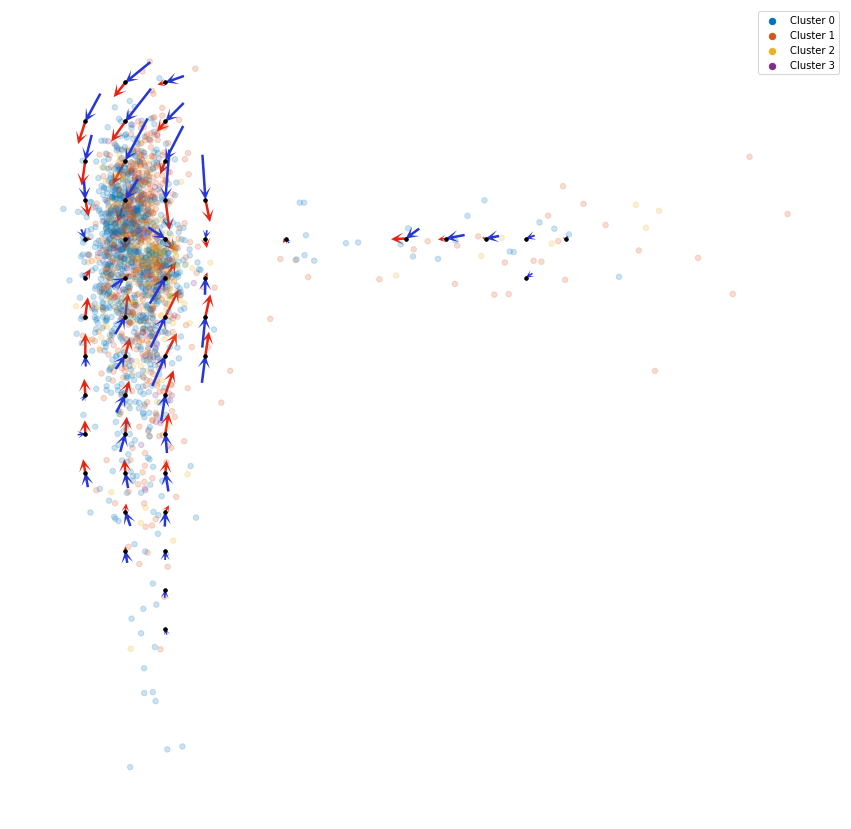

In [22]:
pa.initialize_grid_embedding(vlm)
uv_multiplier = 2.5
pa.calculate_grid_arrows(vlm, "delta_S_in_S_pca", "_rna", min_mass = 1, uv_multiplier = uv_multiplier)
pa.calculate_grid_arrows(vlm, "delta_P_in_S_pca", "_prot", min_mass = 1, uv_multiplier = uv_multiplier)

r_rnav = [231/255, 36/255, 20/255] #Red
b_protv = [38/255, 55/255, 213/255] #Blue
plt.figure(figsize = (15,15))

pa.plot_grid_arrows(vlm, "UV_rna", plot_cells = False, arr_col = r_rnav, arr_scale = 0.1)
pa.plot_grid_arrows(vlm, "UV_prot", plot_cells = True, arr_col = b_protv, color_cells_by_cluster = True, pivot = "tip",
                    arr_scale = 0.1, cell_alpha = 0.2, write_labels = True)
plt.savefig("fig_RNAprotvel_ADTclusters_CustomUMAPtmm/gridEmbedding_PCA.svg", dpi = 700)

Protein acceleration on PCA: Bezier curve. Cell movement is visualized in the embedding using a Bézier curve calculated from three points corresponding to past, present, and future cell states. A high-curvature Bézier curve corresponds to high acceleration.

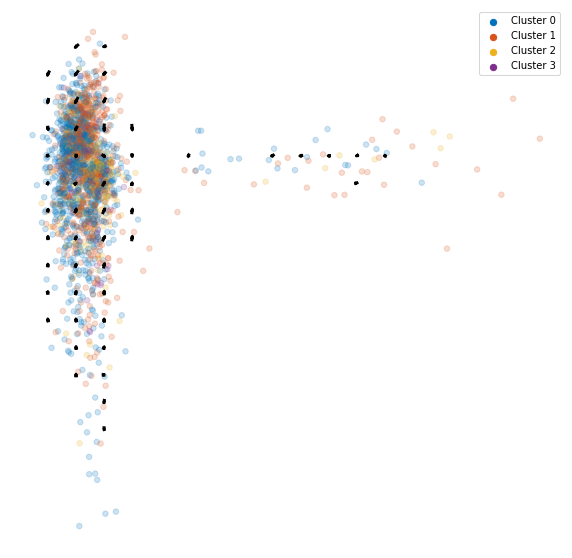

In [23]:
plt.figure(figsize = (10,10))
pa.plot_bezier(vlm, plot_cells = True, color_cells_by_cluster = True, cell_alpha = 0.2, write_labels = True, arr_len_scal = 0.25)
plt.savefig("fig_RNAprotvel_ADTclusters_CustomUMAPtmm/bezier_PCA.svg", dpi = 700)

Loading our UMAP TMM coordinates.

In [24]:
setattr(vlm, "umap", vlm.ca["X_umap_tmm"])
pa.identify_embedding_knn(vlm, "umap", [0,1])

RNA velocities on UMAP:

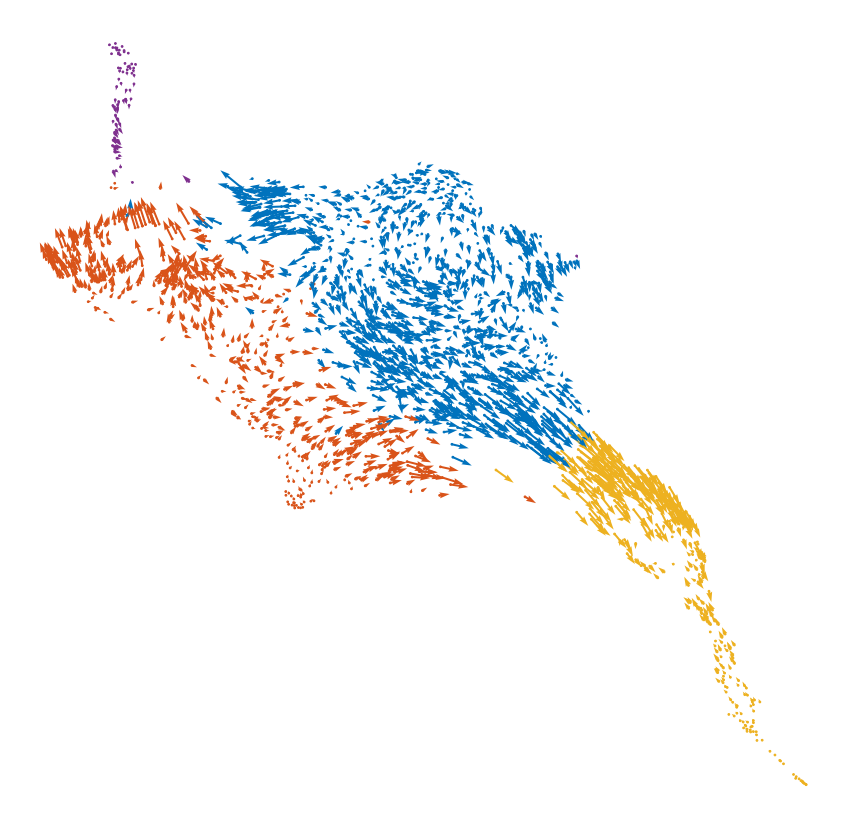

In [25]:
pa.calculate_embedding_delta(vlm, "Sx", "delta_S", "delta_S_in_S_umap", "rna_velo_gene_ind")
plt.figure(figsize = (15,15))
pa.visualize_velocity_projection(vlm, "delta_S_in_S_umap")
plt.savefig("fig_RNAprotvel_ADTclusters_CustomUMAPtmm/RNA_vel_UMAP.svg", dpi = 700)

Protein velocities on UMAP:

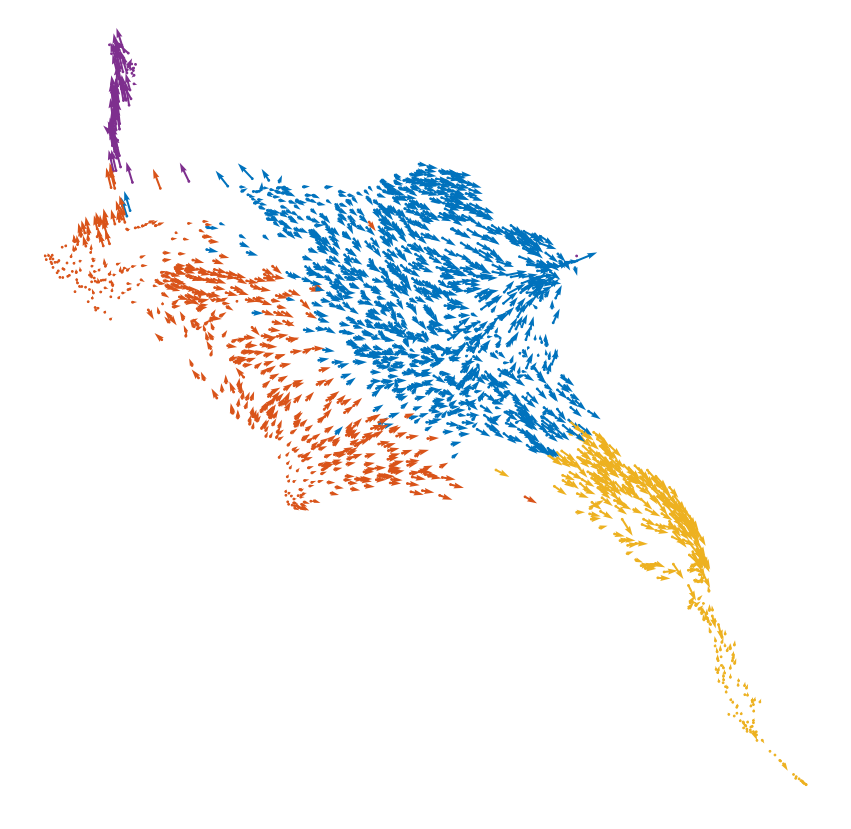

In [26]:
pa.calculate_embedding_delta(vlm, "Px", "delta_P", "delta_P_in_S_umap", "prot_velo_prot_ind")
plt.figure(figsize = (15,15))
pa.visualize_velocity_projection(vlm, "delta_P_in_S_umap")
plt.savefig("fig_RNAprotvel_ADTclusters_CustomUMAPtmm/protein_vel_UMAP.svg", dpi = 700)

Cluster-specific RNA velocities on UMAP:

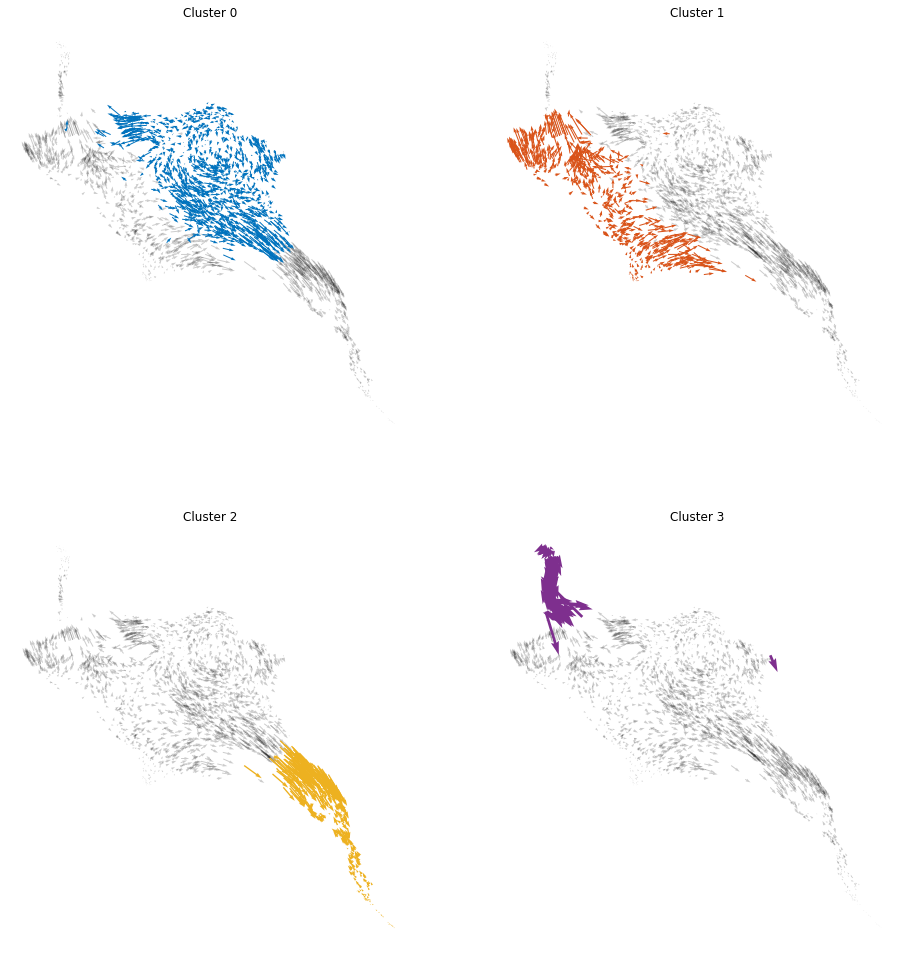

In [27]:
pa.cluster_specific_plot(vlm, "delta_S_in_S_umap", draw_cells = False)
plt.savefig("fig_RNAprotvel_ADTclusters_CustomUMAPtmm/cluster_specific_RNA_vel_UMAP.svg", dpi = 700)

Cluster-specific protein velocities on UMAP:

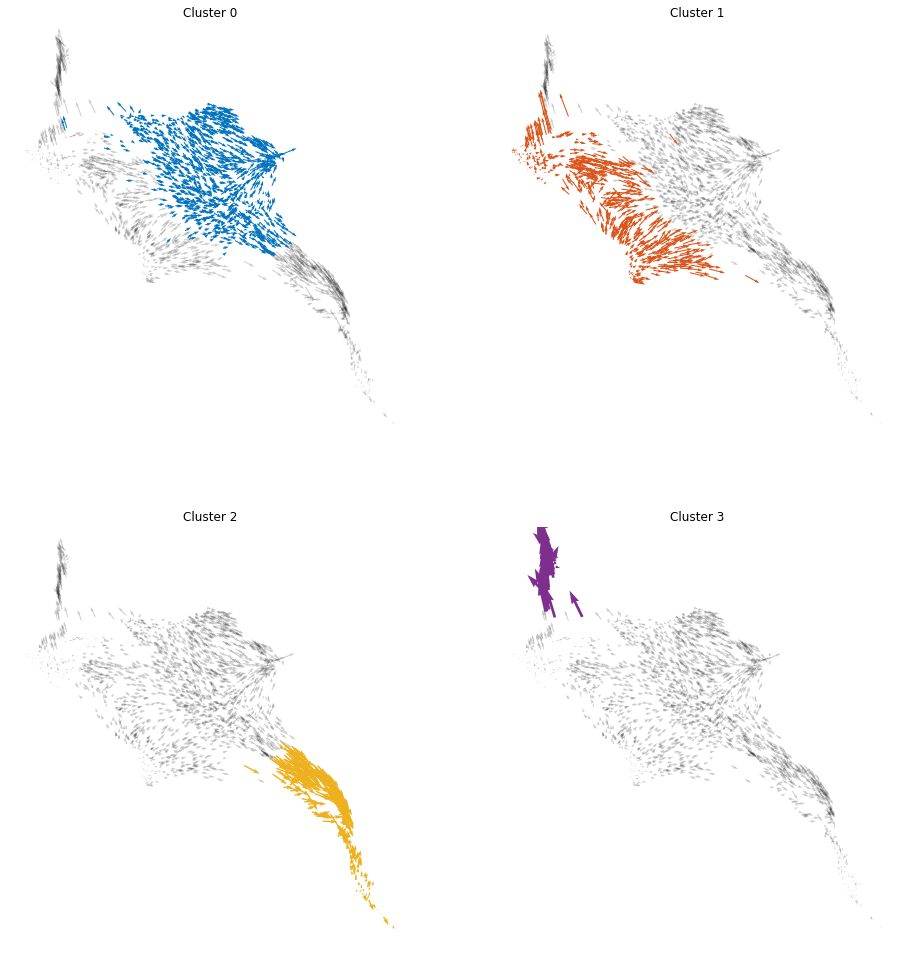

In [28]:
pa.cluster_specific_plot(vlm, "delta_P_in_S_umap", draw_cells = False)
plt.savefig("fig_RNAprotvel_ADTclusters_CustomUMAPtmm/cluster_specific_protein_vel_UMAP.svg", dpi = 700)

Grid embedding:

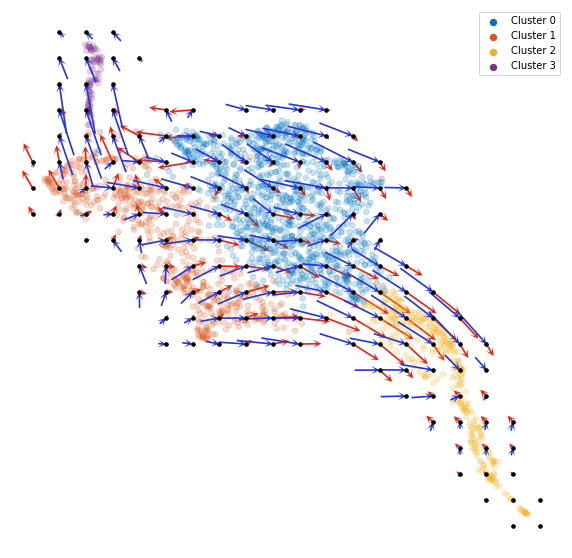

In [29]:
if hasattr(vlm, "mass_filter"):
    delattr(vlm, "mass_filter")
    
pa.initialize_grid_embedding(vlm, n_neighbors = 20)
uv_multiplier = 5

pa.calculate_grid_arrows(vlm, "delta_S_in_S_umap", "_rna", min_mass = 0.5, uv_multiplier = uv_multiplier)
pa.calculate_grid_arrows(vlm, "delta_P_in_S_umap", "_prot", min_mass = 0.5, uv_multiplier = uv_multiplier)

r_rnav = [231/255, 36/255, 20/255] #Red
b_protv = [38/255, 55/255, 213/255] #Blue

plt.figure(figsize = (10,10))
pa.plot_grid_arrows(vlm, "UV_rna", plot_cells = False, arr_col = r_rnav, arr_scale = 4)
pa.plot_grid_arrows(vlm, "UV_prot", plot_cells = True, arr_col = b_protv, color_cells_by_cluster = True, 
                    pivot = "tip", cell_alpha = 0.2, arr_scale = 4, write_labels = True)
plt.savefig("fig_RNAprotvel_ADTclusters_CustomUMAPtmm/gridEmbedding_UMAP.svg", dpi = 700)

Bezier curve: protein acceleration landscape.

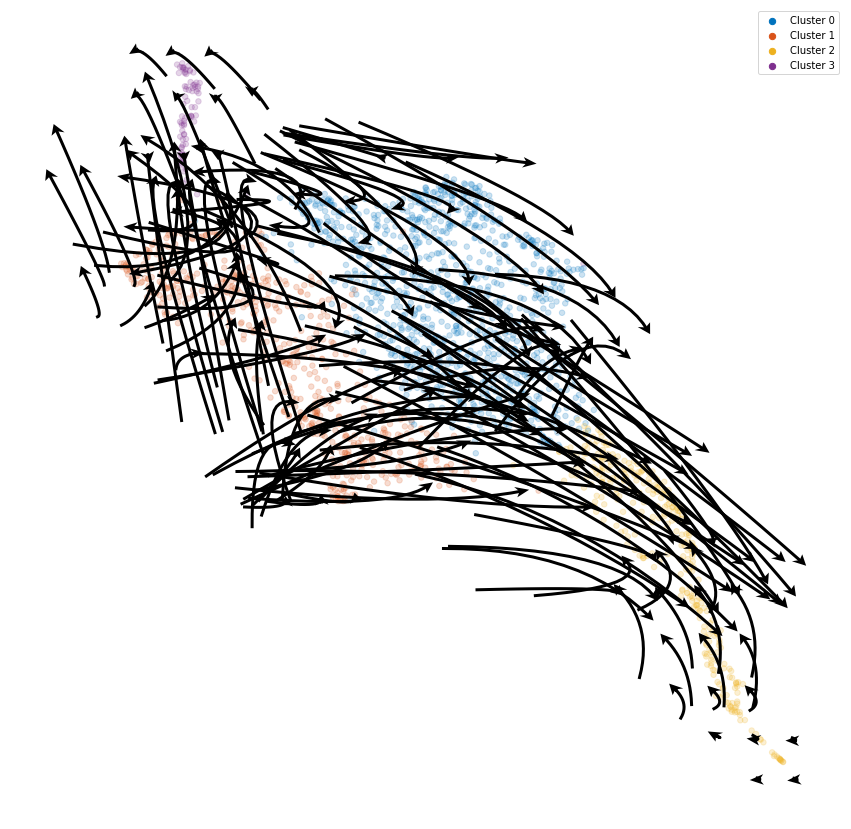

In [30]:
plt.figure(figsize = (15, 15))
pa.plot_bezier(vlm, plot_cells = True, color_cells_by_cluster = True, cell_alpha = 0.2, 
               arr_len_scal = 0.2, write_labels = True)

plt.savefig("fig_RNAprotvel_ADTclusters_CustomUMAPtmm/bezier_UMAP.svg", dpi = 700)